# Discontinuous Conversion Laws
We proceed to solve the 1D Burgers Equation with periodic boundary conditions:
\begin{equation}
    \left\{
    \begin{aligned}
        &\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x} = 0, \qquad x\in \Omega=(0,2\pi), t\in [0, 1.5]\\
        &u(x, 0)=u_0(x),\qquad x\in \Omega=(0,2\pi)\\
        &u(0, t) = u(2\pi, t); u_x(0, t) = u_x(2\pi, t),\qquad t\in [0, 1.5]
    \end{aligned}
    \right.
\end{equation}
where $u_0(x)=sin(x)+0.5$. Equations of this type are particularly challenging to solve due to the presence of discontinuities in their solutions.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import scipy
import time
import os
import time
import matplotlib.animation
from scipy.optimize import fsolve
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.utils.tensorboard import SummaryWriter
from utilities import *
from problems import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## define the exact solution

In [17]:
# x = np.linspace(0, 2*np.pi, 5000)
# t = np.linspace(0, 1.5, 1000)
# xx, tt = np.meshgrid(x, t)
# xx = xx.flatten()
# tt = tt.flatten()
# u_exact = burgers_exact(xx, tt)
# np.save("burgers_exact.npy", u_exact)

# fig = plt.figure(figsize=(8,4))
# ax = fig.add_subplot(111)
# # pic = ax.tricontourf(xt[:,0], xt[:,1], u, levels=100, cmap='jet')
# pic = ax.tricontourf(xx, tt, u_exact, levels=100, cmap='jet')
# fig.colorbar(pic, ax=ax)
# # ax.set_aspect('equal')
# ax.set_xlabel('x')
# ax.set_ylabel('t')

In [8]:
u_exact = np.load("./data/burgers_exact.npy")

## train DGNet

In [3]:
B_dg = Burgers_dg(N_x=11, N_t=30, Nint_x=30, deg=3, num_layers=2, hidden_size=50, act='tanh')
# B.loss()
# retrain = True
# if B.load() and not retrain:
#     print("train loss: ", B.loss())
# elif retrain:
#     # B.load()
#     B.train()
# B.train()
B_dg.load()
print("train loss: ", B_dg.loss())
model = B_dg.model
xt = B_dg.Mesh[:, :, :, :]
u_dg = model(xt).squeeze(-1)
u_dg_exact = B_dg.u_exact.squeeze(-1)
xt_dg = xt.detach().cpu().numpy().reshape(-1, 2)
u_dg = u_dg.detach().cpu().numpy().flatten()
u_dg_exact = u_dg_exact.detach().cpu().numpy().flatten()

/home/data/DGNet/final/utilities.py:330: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  w_solution = fsolve(func, w0)
/home/data/DGNet/final/utilities.py:330: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  w_solution = fsolve(func, w0)


Loading saved model...
train loss:  (tensor(1.6948e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>), tensor(0.0007, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(1.0065, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>))


/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Test Baselines

In [4]:
B_pinn = Burgers_pinn(method='PINN')
# B_pinn.train()
B_pinn.load()
xt_pinn = B_pinn.mesh.reshape(-1, 2)
u_pinn_exact = B_pinn.u_exact.reshape(-1).detach().cpu().numpy()
u_pinn = B_pinn.model(torch.tensor(xt_pinn, dtype=torch.float32).to(device)).detach().cpu().numpy().flatten()


Loading saved model...


In [5]:
B_hpVPINN = Burgers_hpVPINN(N_x=3, N_t=100, Nint_x=40, deg=10, num_layers=3, hidden_size=128, act='tanh')
# B_hpVPINN.train()
model = B_hpVPINN.model
B_hpVPINN.load()
xt = B_hpVPINN.Mesh[:, :, :, :]
u_hpVPINN = model(xt).squeeze(-1)
u_hpVPINN_exact = B_hpVPINN.u_exact.squeeze(-1)

xt_hpVPINN = xt.detach().cpu().numpy().reshape(-1, 2)
u_hpVPINN = u_hpVPINN.detach().cpu().numpy().flatten()
u_hpVPINN_exact = u_hpVPINN_exact.detach().cpu().numpy().flatten()


Loading saved model...


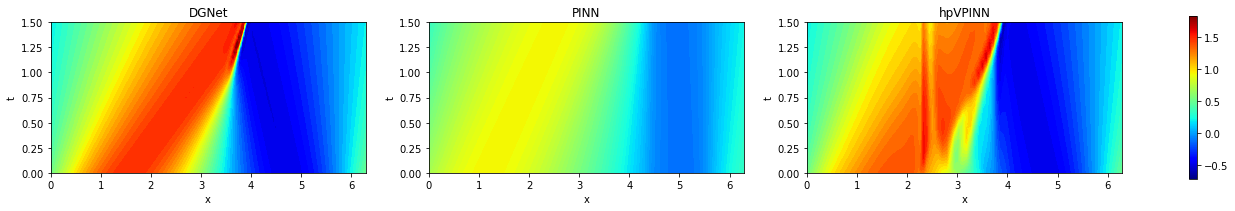

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(24, 3))
vmin = min(u_exact.min(), u_dg.min(), u_pinn.min(), u_hpVPINN.min())
vmax = max(u_exact.max(), u_dg.max(), u_pinn.max(), u_hpVPINN.max())

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("jet")

a = axes[0].tricontourf(xt_dg[:, 0], xt_dg[:, 1], u_dg, levels=50, cmap=cmap, norm=norm)
b = axes[1].tricontourf(xt_pinn[:, 0], xt_pinn[:, 1], u_pinn, levels=50, cmap=cmap, norm=norm)
c = axes[2].tricontourf(xt_hpVPINN[:, 0], xt_hpVPINN[:, 1], u_hpVPINN, levels=50, cmap=cmap, norm=norm)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='vertical')

axes[0].set_title("DGNet")
axes[1].set_title("PINN")
axes[2].set_title("hpVPINN")
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[0].set_aspect(2)
axes[1].set_aspect(2)
axes[2].set_aspect(2)

plt.show()

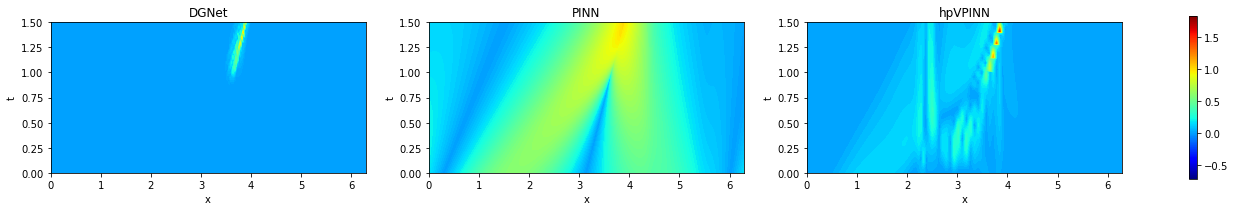

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(24, 3))
a = axes[0].tricontourf(xt_dg[:, 0], xt_dg[:, 1], abs(u_dg-u_dg_exact), levels=50, cmap=cmap, norm=norm)
b = axes[1].tricontourf(xt_pinn[:, 0], xt_pinn[:, 1], abs(u_pinn-u_pinn_exact), levels=50, cmap=cmap, norm=norm)
c = axes[2].tricontourf(xt_hpVPINN[:, 0], xt_hpVPINN[:, 1], abs(u_hpVPINN-u_hpVPINN_exact), levels=50, cmap=cmap, norm=norm)


cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='vertical')

axes[0].set_title("DGNet")
axes[1].set_title("PINN")
axes[2].set_title("hpVPINN")
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[0].set_aspect(2)
axes[1].set_aspect(2)
axes[2].set_aspect(2)

plt.show()

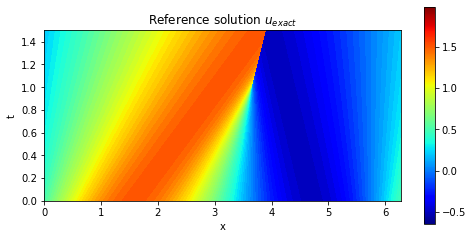

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
x = np.linspace(0, 2*np.pi, 5000)
t = np.linspace(0, 1.5, 1000)
xx, tt = np.meshgrid(x, t)
xx = xx.flatten()
tt = tt.flatten()

# 绘制等高填充图
pic = ax.tricontourf(xx, tt, u_exact, levels=50, cmap=cmap, norm=norm)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', aspect=20)

# 设置标题
ax.set_title("Reference solution $u_{exact}$")
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_aspect(2)

plt.show()

# End